<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Recurrent_Neural_Network/W2V_(skip_gram_architecure).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal:
My primary goal of this notebook is to implement the embedded word2vector algorithm "SKIP GRAM" using PyTorch. I will use some information and guidance from Cezanne Camacho's notebook and try to implement logic from Research Paper : "Efficient Estimation of Word Representations in Vector Space". 

### Word Embedding:
When we deal with the text data, one of the biggest problem is to its conversion in numerical data and it done by hot encoding. But, in one hot encoding, most of values set tobe zero. The result of first layer with weights will return huge matrix with most of zero valued hidden output. (hidden layer).

Now, here the idea of RP is to develop a embedded layer which is same as fully connected layer and instead of doing any kind of multiplication (W* x +b = y), we should directly grab weights (W) of correspoiding encoded row (which have one, because W*1 = W). With this we not only skip the multiplication, but the computation complexity and time complexity of model will reduce significantly. Its hard to understand then lets implement it.  

Note: Embedded is not only the use of Word2Vect, some practical example where we have huge no. of classes. 

---

### Word2Vec
Now, move to main point...
- Word2vec works same as its name that shows vectore representation of the Word. So, if some words have good correlation will have smaller distance to each other in vector space. If same category of words links to some specific word / phrase will have vector relationship and connection to eachother. How?

> - Example : I drink tea. You drink coffee. He drinks water. Then, all the words **tea, coffee, water** must have some relationship with **drink**. and inaddition, complex network can understands the same meaning of word **drink** and **drinks**. 

---
NOTEBOOK: SKIP_GRAM ARCHITECTURE

---

## Loading Data 
Here, I use wikipedia data as project dataset. It has size of 30 MB. ~= 30 M text characters for training. 

In [1]:
# read text file
with open('/content/wiki') as f:
  text = f.read()

# print first 500 charaters;
print(text[0:500])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


## Preprocessing

The main preprocessing tasks are:
1. Remove words which used fewer times, as they have less relations and poor connections with other data, may create noise. 
2. Coverts any punctuations and periods in to the tocken. 
3. Convert each word into the list for letter use. 




In [2]:
# preprocess the data 
import re
from collections import Counter

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

# return list of words
words = preprocess(text)
print(words[0:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# prior analysis of data 
print("Total words in the text data: ", len(words))
print("Totla unique words in the text data: ", len(set(words)))

Total words in the text data:  16680599
Totla unique words in the text data:  63641


Now, I am creating two dictionary, one of which is word2vec and another will be vec2word, using special function. The integer assigned in descending order. so most frequent word will be in first position and less frequnt word becomes at last. 

Now, the words are in the list, for proper use we need dictionaries. So, lets convert them to dictionary. 

In [4]:
def create_lookup_table(words):
  word_counts = Counter(words)                                                  # count each unique words ex: 'the' : 1235
  sorted_vocab = sorted(word_counts, key= word_counts.get, reverse = True)      # sorting words in list
  int_to_vocab = {n: word for n, word in enumerate(sorted_vocab)}               # dictionary1 of int : vocab
  vocab_to_int = {word: n for n, word in enumerate(sorted_vocab)}               # dictionary2 of vocab : int
  # print(vocab_to_int)
  return vocab_to_int, int_to_vocab

# Applied function Arg.
vocab_to_int, int_to_vocab = create_lookup_table(words)
int_words = [vocab_to_int[word] for word in words]                              # keep index only for words .
print("=========== CONVERT EACH TEXT DATA TO CORRESPONDING INT(INDEX) VALUE - TOKENS===================")
print(words[0:30])
print(int_words[:30])
print(len(int_words))

=========== CONVERT EACH TEXT DATA TO CORRESPONDING INT(INDEX) VALUE - TOKENS===================
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']
[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]
16680599


The total length of list is 8,23,962 words for which we need to train, But, as we know some words are too much frequent in text. It mostly includes, pronoun, prepositions and verbs for be. So, the best mehtod is to subsampling such terms for noise reduction and better result. 

From research paper's section 2.3, equeation 5 give us logic for subsampling of data. which is ...

> $$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$




In [5]:
from collections import Counter
import random 
import numpy as np 

threshold = 1e-5
word_counts = Counter(int_words)                                                # how many time word repeat                                     
print(list(word_counts.items())[0:6])


total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1- np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() <(1- p_drop[word])]# define final equation probability.
print(train_words[:30])                                                         # word (token) to repeatation.

[(5233, 303), (3080, 572), (11, 131815), (5, 325873), (194, 7219), (1, 593677)]
[5233, 3080, 10571, 27349, 102, 15067, 58112, 3580, 194, 58, 10712, 214, 454, 708, 53, 2757, 7088, 247, 5233, 44611, 602, 1134, 8983, 6437, 153, 5233, 1818, 4860, 7573, 1774]


## Making Batches

I get an idea of skip gram architecutre from paper and related material that, it works as -+range from origion word. So, for each word in the text we need to define the surrounding context and grab the words in the windows. The windows represents the range. 

As an example we have 100 word list and then a rondom number R is chose from certain range the nat specific word, the architecture will track all the R words in history and R words in future. means... for word no. 8, if R = 2 then the range will become (8-2 = 6) and (8 + 2 = 10). 

In [6]:
def get_target(words, idx, window_size):
  R = np.random.randint(1, window_size+1)                                       # due to indexing start from 1
  start = idx-R if (idx-R)>0 else 0
  stop = idx+R 
  target_words = words[start:idx] + words[idx+1:stop+1] 
  return list(target_words)                        

In [7]:
def get_batches(words, batch_size, window_size = 5):                            # here, batch_size decide no. of elements take part in operation,                                                                                   
  n_batches = len(words)//batch_size                                            # ...where windows decide out of participant element how many word range can make their pairs.
  words = words[:batch_size*n_batches]                                          # remove uncomplete batch elements.

  for idx in range(0, len(words), batch_size):                         
    x, y = [], []
    batch = words[idx: idx+batch_size]
    # print(batch)
    for i in range(len(batch)):
      batch_x = batch[i]
      batch_y = get_target(batch, i, window_size)
      y.extend(batch_y)
      x.extend([batch_x]*len(batch_y))
    yield x,y

'''
NOTE: return sends a specified value back to its caller, whereas yield can produce a sequence of values. We should use yield 
when we want to iterate over a sequence but don't want to store the entire sequence in memory. yield is used in Python
'''

"\nNOTE: return sends a specified value back to its caller, whereas yield can produce a sequence of values. We should use yield \nwhen we want to iterate over a sequence but don't want to store the entire sequence in memory. yield is used in Python\n"

In [8]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size= 6 ,window_size= 2))

print('x : ', x)
print("============")
print('y :', y)

x :  [0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5]
y : [1, 0, 2, 3, 0, 1, 3, 4, 2, 4, 2, 3, 5, 4]


## SKIP_GRAM Model:

#### Logic:
The basic logic after skip_gram model is to use one hidden layer with linear connection, generally called embeded matrix layer. So, for total words in the vector W most of are zeros except one corresponding 1 for specific word. and the matrix (weight) weill be in shape of (W x features). but the simple matrix multiplication will become a weight matrix' corresponding row only because it multiply with 1 and others with 0 will result zero. The hidden layer does not have any activation function. But, the output layer must have softmax activation to decide the other word's probability. 

You can see the model as follow:

![]() 

--- 
Here, I will implement the same logic with the use of PyTorch. 

but, before that the another concerned topic is about its validation, that how can we use validation to ensure ourself that how close our model really generate closest word with actual one. 

From, RP we can do it by cosine similarity. Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity:

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

![]()

We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [22]:
# validation check
def cosine_similarity(embedding, valid_size = 16,valid_window=100,device='cpu'):
  # implement logic 
  embed_vectors = embedding.weight
  magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
  # pick top words out of result
  valid_examples = np.array(random.sample(range(valid_window),valid_size//2))
  valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window),valid_size//2))
  valid_examples = torch.LongTensor(valid_examples).to(device)
  valid_vectors = embedding(valid_examples)
  similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes           # function logic (eq.)
  return valid_examples, similarities

In [10]:
import torch
from torch import nn
import torch.optim as optim 

In [11]:
# generate skip_gram architecture
class skip_gram(nn.Module):
  def __init__(self, n_vocab, n_embed):
    super().__init__()
    self.embed = nn.Embedding(n_vocab,n_embed)
    self.output = nn.Linear(n_embed,n_vocab)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self,x):
    x = self.embed(x)
    scores = self.output(x)
    log_ps = self.log_softmax(scores)
    return log_ps

In [29]:
# Generate regular ML model training flow
device = 'cuda' if torch.cuda.is_available() else 'cpu'                         # check gpu availability.
print('Device for Training : ', device)
print(" ============== Let's Start ============ ")

embedding_dim = 300                                                             # consider 300, intuite from google_news data modeling.

model = skip_gram(len(vocab_to_int),embedding_dim).to(device)                   # load model to device
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

print_every = 500
steps = 0
epochs = 5

# implement training loop
for e in range(epochs):
  print("--------------")
  print('| epoch no:{} |'.format(e))
  print("--------------")
  
  for inputs, targets in get_batches(train_words, batch_size=512):
    steps += 1
    inputs,targets = torch.LongTensor(inputs), torch.LongTensor(targets)
    inputs,targets = inputs.to(device), targets.to(device)

    log_ps = model(inputs)
    loss = criterion(log_ps,targets)
    optimizer.zero_grad()                                                       # clear all gradients from the last steps
    loss.backward()                                                             # calculate derivaties of loss w.r.t. parameters (using backpropagation)
    optimizer.step()                                                            # caused optimizer to take step, based gradients of parameters

    # validation and similarities bet'n words.
    if steps%print_every==0:
      print(steps)
      valid_examples,valid_similarites = cosine_similarity(model.embed,device= device)
      _,closest_idxs = valid_similarites.topk(6)

      valid_examples, closest_idxs = valid_examples.to('cpu'),closest_idxs.to('cpu')
      # print result
      for i, valid_idx in enumerate(valid_examples):
        closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[i]][1:]
        print(int_to_vocab[valid_idx.item()] + " ... closest words are : " + ','.join(closest_words))
      print("... continuing training ...")

Device for Training :  cuda
 ============== Let's Start ============ 
epoch no:  0
500
american ... closest words are : triode,equipment,algorism,communally,inaugurate
was ... closest words are : catholics,entrant,mcdonough,universitaire,zemlya
state ... closest words are : bellerophon,avenger,travis,franciscan,forgery
states ... closest words are : summary,latencies,sumo,sakya,cuneiform
often ... closest words are : irreducible,pecos,knebworth,zr,gathers
seven ... closest words are : villeneuve,references,promiscuity,christiania,deal
used ... closest words are : sale,bypassed,tisza,atari,mato
they ... closest words are : increases,offend,oscilloscopes,greta,sepsis
report ... closest words are : warming,abn,leiserson,midair,bacterium
ocean ... closest words are : knowingly,selby,amongst,academia,yuki
operating ... closest words are : joins,arrangement,tackles,geopolitically,evangelistic
accepted ... closest words are : fenrisulfr,volkssturm,appaloosa,nintendo,armas
marriage ... closest

## Visualize the word vectors



In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

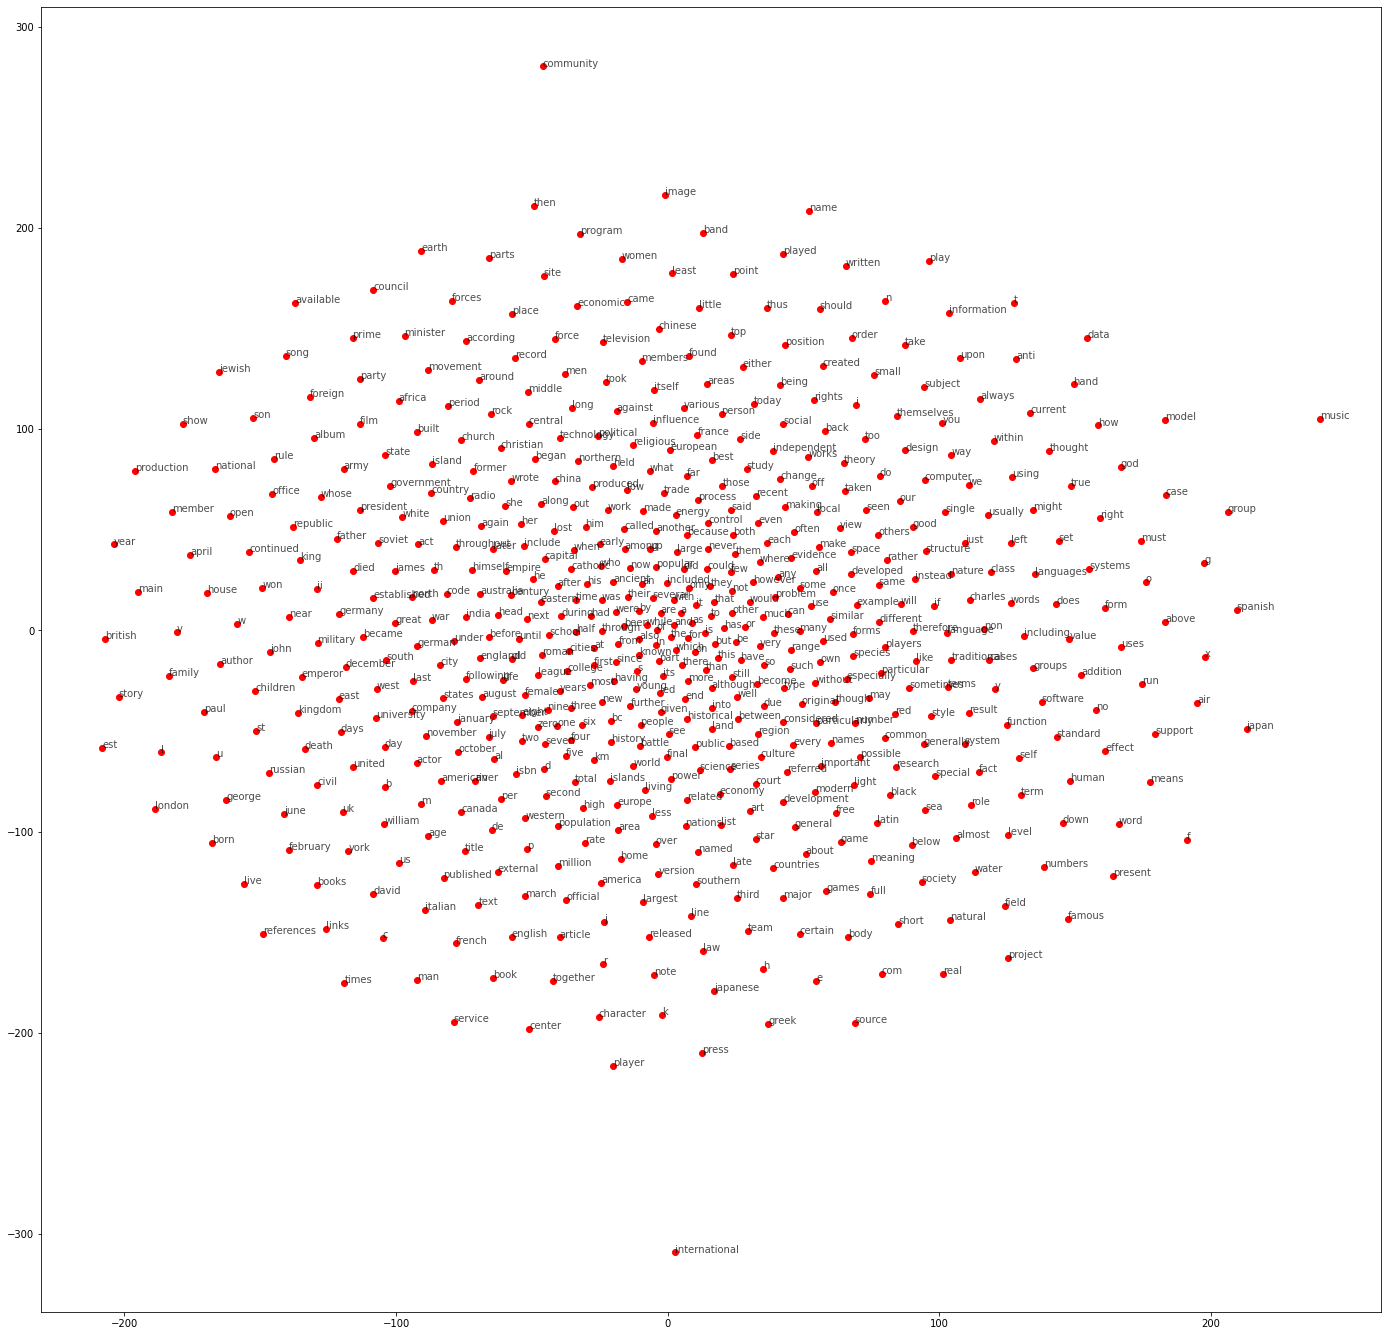

In [31]:
# seperate embedding layer out of the model
embeddings = model.embed.weight.to('cpu').data.numpy()

viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words,:])

fig, ax = plt.subplots(figsize=(24,24))
for idx in range(viz_words):
  plt.scatter(*embed_tsne[idx,:], color= 'red')
  plt.annotate(int_to_vocab[idx],(embed_tsne[idx,0],embed_tsne[idx,1]),alpha= 0.7)